In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import pqcd
import h5py

from universality.gaussianprocess.utils import integrate_phi
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

In [2]:
pqcd_region_dict = pqcd.get_pqcd_region(mu_high=3, res=200)

Plot the default pQCD region

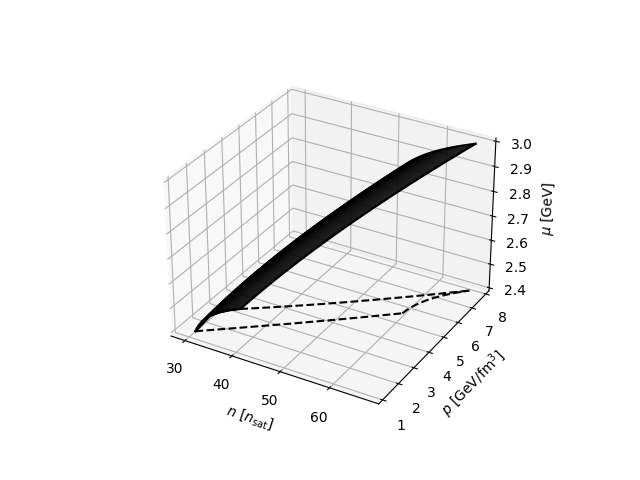

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

Overplot some EOSs

In [8]:
set = 25
good_EOSs = []

N_samp = 10000

for variety in ['marg']:
    for n in range(N_samp):
        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            good_EOSs.append((variety, n))

In [9]:
len(good_EOSs)

10000

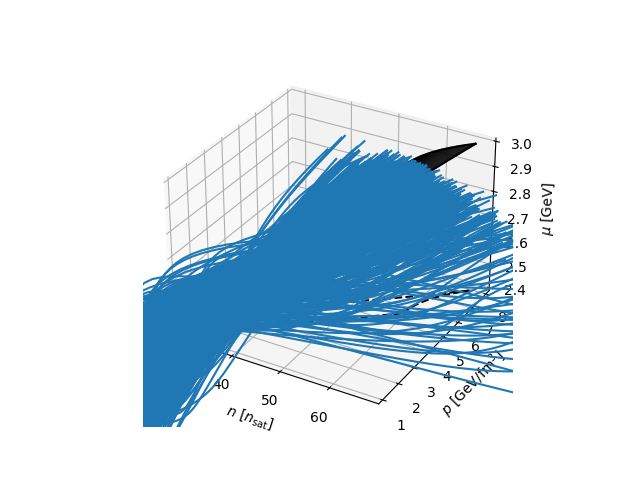

In [10]:
# A plot with the full EOS
# ------------------------

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for variety, n in good_EOSs:

    eos = pd.read_csv(
        f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    ax.plot(
        number_density/nsat, 
        pressure,
        chemical_potential,
        c='C0'
    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

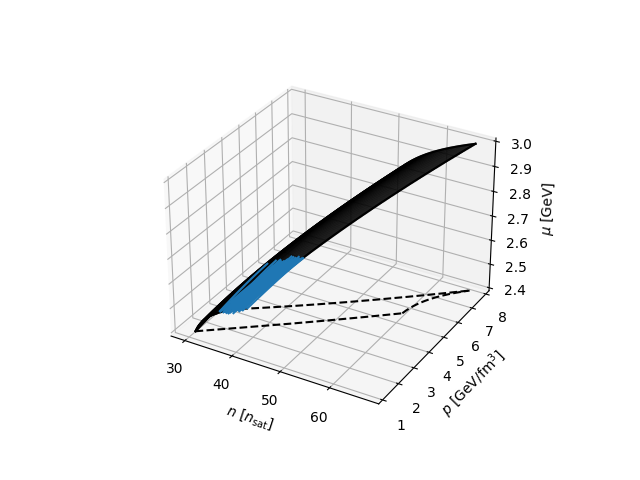

In [7]:
# Include some EOSs that don't hit the pQCD region

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

N_samp = 100

for variety in ['qrk']:

    for n in range(N_samp):

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c = 'C0'
        else:
            c = 'C3'

        pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density

        mask = (chemical_potential > 2.4) & (chemical_potential < 2.6)

        ax.plot(
            number_density[mask]/nsat, 
            pressure[mask],
            chemical_potential[mask],
            c=c
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

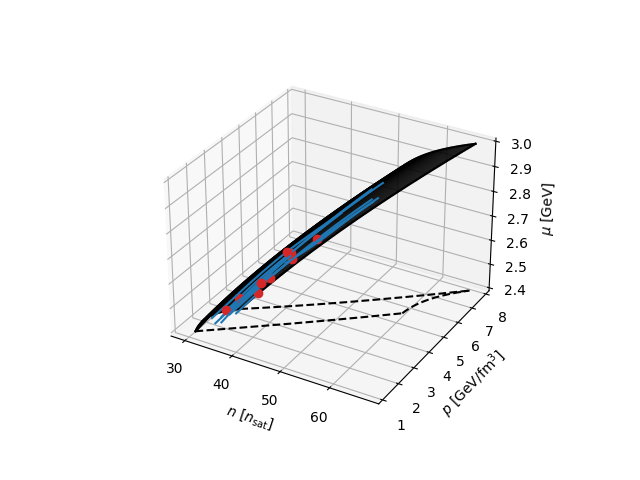

In [14]:
# Plot with a windowed EOS around the pQCD region
# -----------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for variety, n in good_EOSs:

    if 9000 < n < 9010:

        eos = pd.read_csv(
            f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
            )

        pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density

        inside_region_n = []
        inside_region_p = []
        inside_region_mu = []

        for n, p, mu in zip(number_density, pressure, chemical_potential):
            if pqcd_region_dict['p_boundary_min'] < p < pqcd_region_dict['p_boundary_max']:
                min_n = pqcd_region_dict['left_n_boundary'][np.argmin(np.abs(pqcd_region_dict['left_p_boundary']-p))]
                max_n = pqcd_region_dict['right_n_boundary'][np.argmin(np.abs(pqcd_region_dict['right_p_boundary']-p))]
                if min_n < n < max_n:
                    inside_region_n.append(n)
                    inside_region_p.append(p)
                    inside_region_mu.append(mu)

        # Find the location where the EOS crosses the surface

        # Variable to keep track of the smallest distance between our EOS and 
        # the PQCD boundary
        delta = 10

        for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
            for dense_mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
                distances = (dense_n_array-n)**2 + (dense_p_array-p)**2 + (dense_mu-mu)**2
                near_point_index = np.argmin(distances)
                proposed_delta = distances[near_point_index]
                if proposed_delta < delta:
                    delta = proposed_delta
                    near_point = (dense_n_array[near_point_index], dense_p_array[near_point_index], dense_mu)

        ax.plot(
            np.array(inside_region_n)/nsat, 
            inside_region_p,
            inside_region_mu,
            c='C0'
        )

        ax.plot(
            near_point[0]/nsat, near_point[1], near_point[2],
            c='C3',
            marker='o'
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

Repeat for a higher upper bound on mu

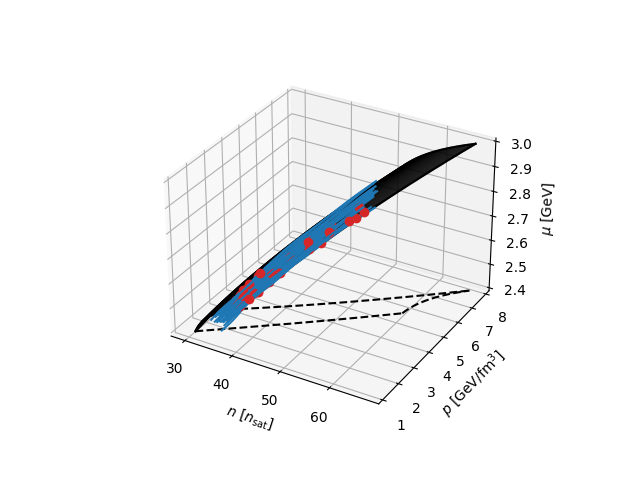

In [2]:
pqcd_region_dict = pqcd.get_pqcd_region(mu_high=3, res=200)

set = 8
good_EOSs = []

N_samp = 5000

for variety in ['qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(
            f'../data/eos-draws-modified/tests/{set:02}/{variety}agn/'
            f'DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
        )
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            good_EOSs.append((variety, n))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
    )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

for variety, n in good_EOSs:

    eos = pd.read_csv(
        f'../data/eos-draws-modified/tests/{set:02}/{variety}agn/'
        f'DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    inside_region_n = []
    inside_region_p = []
    inside_region_mu = []

    for n, p, mu in zip(number_density, pressure, chemical_potential):
        if pqcd_region_dict['p_boundary_min'] < p < pqcd_region_dict['p_boundary_max']:
            min_n = pqcd_region_dict['left_n_boundary'][np.argmin(np.abs(pqcd_region_dict['left_p_boundary']-p))]
            max_n = pqcd_region_dict['right_n_boundary'][np.argmin(np.abs(pqcd_region_dict['right_p_boundary']-p))]
            if min_n < n < max_n:
                inside_region_n.append(n)
                inside_region_p.append(p)
                inside_region_mu.append(mu)

    # Find the location where the EOS crosses the surface

    # Variable to keep track of the smallest distance between our EOS and 
    # the PQCD boundary
    delta = 10

    for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
        for dense_mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
            distances = (dense_n_array-n)**2 + (dense_p_array-p)**2 + (dense_mu-mu)**2
            near_point_index = np.argmin(distances)
            proposed_delta = distances[near_point_index]
            if proposed_delta < delta:
                delta = proposed_delta
                near_point = (dense_n_array[near_point_index], dense_p_array[near_point_index], dense_mu)

    ax.plot(
        np.array(inside_region_n)/nsat, 
        inside_region_p,
        inside_region_mu,
        c='C0'
    )

    ax.plot(
        near_point[0]/nsat, near_point[1], near_point[2],
        c='C3',
        marker='o'
    )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xlabel(r'$n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')

In [3]:
len(good_EOSs)

38

In [4]:
mu_highs = np.linspace(2.4, 3.2, 17)
good_EOSs = []

set = 8
N_samp = 5000

for mu_high in mu_highs:
    count = 0
    if mu_high != 2.4:
        pqcd_region_dict = pqcd.get_pqcd_region(mu_high=mu_high, res=int(25*20*(mu_high-2.4)))
        for variety in ['qrk']:
            for n in range(N_samp):
                eos = pd.read_csv(
                    f'../data/eos-draws-modified/tests/{set:02}/{variety}agn/'
                    f'DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
                )
                if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                    count += 1
    good_EOSs.append(count)

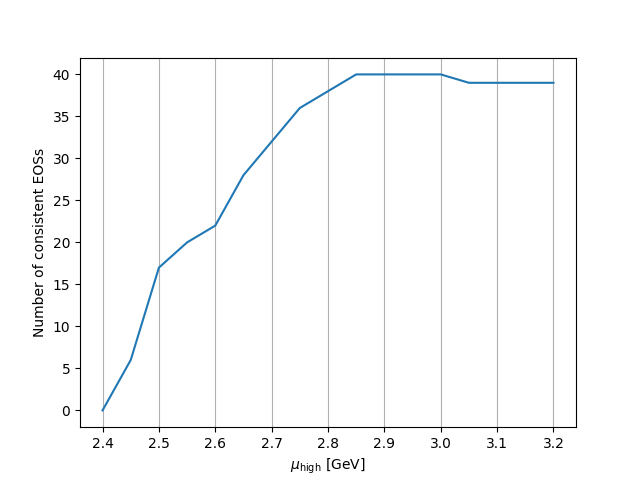

In [5]:
fig, ax = plt.subplots()

ax.plot(mu_highs, good_EOSs)

ax.grid(axis='x')

ax.set_xlabel(r'$\mu_{\rm high}$ [GeV]')
_ = ax.set_ylabel('Number of consistent EOSs')

Plot means in 3D

In [6]:
set = 6
gp_mean_dict = {}

for variety in ['had', 'hyp', 'qrk']:

    hdf5_path = f'../data/eos-draws-modified/tests/{set:02}/{variety}agn/gpr_gpr_{variety}agn.hdf5'

    gp_mean_dict[variety] = {}

    with h5py.File(hdf5_path, 'r') as f:
        for key in f.keys():

            cov = np.array(f[key]['cov'])
            mean = np.array(f[key]['mean'])

            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])

            gp_mean_dict[variety][key] = (log_pressure, phi)

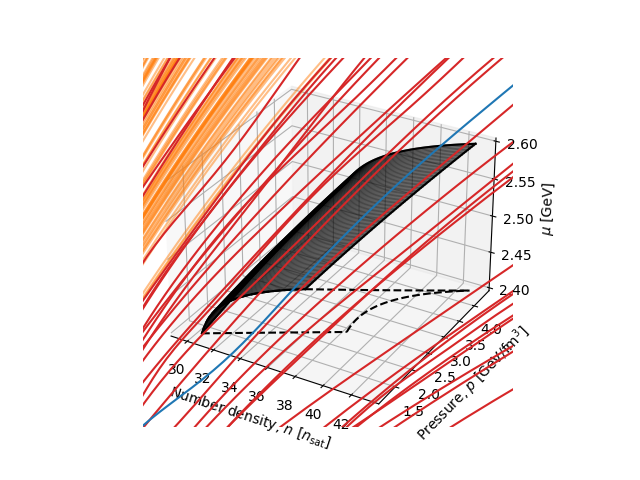

In [7]:
pqcd_region_dict = pqcd.get_pqcd_region()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(4):
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_boundary_arrays'][i],
        c='k'
        )
    ax.plot(
        pqcd_region_dict['n_boundary_arrays'][i]/nsat,
        pqcd_region_dict['p_boundary_arrays'][i],
        pqcd_region_dict['mu_array'][0],
        c='k',
        ls='--'
    )
    
for mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
    ax.plot(np.array(dense_n_array)/nsat, dense_p_array, mu, c='k', alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

set = 6
N_samp = 20

for variety in ['had', 'hyp', 'qrk']:
    for key in gp_mean_dict[variety].keys():
        
        log_pressure, phi = gp_mean_dict[variety][key]

        eos, cols = integrate_phi(
            np.exp(log_pressure),
            phi,
            reference_pressurec2=3e11,
            sigma_logpressurec2=0,
            stitch_below_reference_pressure=True,
            include_baryon_density=True,
            include_cs2c2=True,
            include_baryon_chemical_potential=False,
            verbose=False
        )

        pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
        energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
        number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

        chemical_potential_mean = (energy_density_mean+pressure_mean)/number_density_mean

        ax.plot(number_density_mean/nsat, pressure_mean, chemical_potential_mean, c='C1', alpha=0.5)

for variety in ['had', 'hyp', 'qrk']:

    for n in range(N_samp):

        eos = pd.read_csv(f'../data/eos-draws-modified/tests/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c = 'C0'
        else:
            c = 'C3'

        pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density

        ax.plot(
            number_density/nsat, 
            pressure,
            chemical_potential,
            c=c
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

# labels = ['GP means', 'consistent with PQCD', 'inconsistent with PQCD']
# handles = [
#     plt.Line2D([0], [0], color='C1'), 
#     plt.Line2D([0], [0], color='C0'), 
#     plt.Line2D([0], [0], color='C3')
#     ]

# ax.legend(handles, labels, loc='upper left')

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_zlabel(r'$\mu$ [GeV]')